In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale
from IPython.display import display, clear_output
import os 
from pathlib import Path
import uproot
import pandas as pd

In [12]:
#Reading in CT scan Data 
import nibabel as nib

img = nib.load("LondonPride_000101_dynPET.img")
pet_data = img.get_fdata() 

print(pet_data.shape)

(182, 218, 182, 23)


(182, 218)
(182, 182)


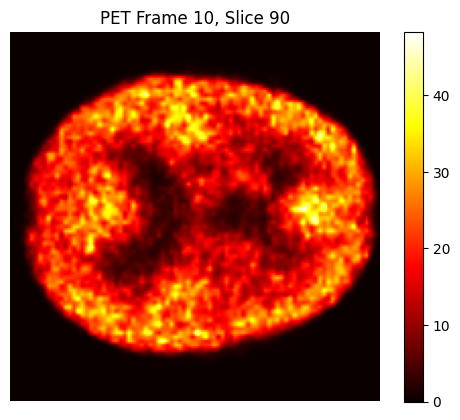

In [13]:
import matplotlib.pyplot as plt

# Pick a slice and frame to view
z = 90          # mid-brain
frame = 10       # first time frame


true_object = pet_data[:, :, z, frame]
print(true_object.shape)

def crop_to_square(img):
    h, w = img.shape
    min_dim = min(h, w)
    top = (h - min_dim) // 2
    left = (w - min_dim) // 2
    return img[top:top + min_dim, left:left + min_dim]

true_object_cropped = crop_to_square(true_object)
print(true_object_cropped.shape)  # e.g. (182, 182)

plt.imshow(true_object_cropped, cmap='hot')
plt.title(f"PET Frame {frame}, Slice {z}")
plt.axis('off')
plt.colorbar()
plt.show()


In [4]:
'''from matplotlib.collections import LineCollection

def plot_physical_positions(coincidences_df: pd.DataFrame, ax=None):
    """
    Plot physical positions of coincidence pairs in the x-y plane using vectorized drawing.
    
    For each coincidence pair, the two positions are plotted as small semi-transparent dots,
    and a semi-transparent red line is drawn connecting them. This version uses vectorized
    operations (via a LineCollection and bulk scatter) to dramatically speed up plotting
    for large numbers of pairs.
    
    Parameters:
        coincidences_df (pd.DataFrame): DataFrame with coincidence pairs,
            containing at least the columns:
                'PostPosition_X_1', 'PostPosition_Y_1',
                'PostPosition_X_2', 'PostPosition_Y_2'.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Extract the arrays of coordinates.
    x1 = coincidences_df["PostPosition_X_1"].values
    y1 = coincidences_df["PostPosition_Y_1"].values
    x2 = coincidences_df["PostPosition_X_2"].values
    y2 = coincidences_df["PostPosition_Y_2"].values

    # Build an array of segments for the red lines.
    # Each segment is defined as [[x1, y1], [x2, y2]]
    segments = np.stack([np.column_stack((x1, y1)), np.column_stack((x2, y2))], axis=1)

    # Create a LineCollection from all segments.
    line_collection = LineCollection(segments, colors='white', linewidths=0.5, alpha=0.05)
    ax.add_collection(line_collection)

    # Plot all blue dots at once.
    ax.scatter(x1, y1, color='blue', s=20, alpha=0.5, zorder=3)
    ax.scatter(x2, y2, color='blue', s=20, alpha=0.5, zorder=3)

    ax.set_xlabel("PostPosition_X")
    ax.set_ylabel("PostPosition_Y")
    ax.set_facecolor("black")
    ax.set_title("Coincidence Pairs: Physical Positions")

    #plt.tight_layout()
    #plt.show()'''

'from matplotlib.collections import LineCollection\n\ndef plot_physical_positions(coincidences_df: pd.DataFrame, ax=None):\n    """\n    Plot physical positions of coincidence pairs in the x-y plane using vectorized drawing.\n    \n    For each coincidence pair, the two positions are plotted as small semi-transparent dots,\n    and a semi-transparent red line is drawn connecting them. This version uses vectorized\n    operations (via a LineCollection and bulk scatter) to dramatically speed up plotting\n    for large numbers of pairs.\n    \n    Parameters:\n        coincidences_df (pd.DataFrame): DataFrame with coincidence pairs,\n            containing at least the columns:\n                \'PostPosition_X_1\', \'PostPosition_Y_1\',\n                \'PostPosition_X_2\', \'PostPosition_Y_2\'.\n    """\n    if ax is None:\n        fig, ax = plt.subplots(figsize=(8, 8))\n    \n    # Extract the arrays of coordinates.\n    x1 = coincidences_df["PostPosition_X_1"].values\n    y1 = coinci

In [5]:
'''#Reading in Sinogram Data

data = np.load("output/sinogram_data.npz")
sinogram = data["sinogram"]
theta_centers = data["theta_centers"]
r_edges = data["r_edges"]

print("Sinogram shape:", sinogram.shape)
print("Theta bins:", len(theta_centers))
print("R bins (from edges):", len(r_edges) - 1)


#Reading in Coincidences DF

coincidences_df = pd.read_csv("output/coincidences.csv")'''

'#Reading in Sinogram Data\n\ndata = np.load("output/sinogram_data.npz")\nsinogram = data["sinogram"]\ntheta_centers = data["theta_centers"]\nr_edges = data["r_edges"]\n\nprint("Sinogram shape:", sinogram.shape)\nprint("Theta bins:", len(theta_centers))\nprint("R bins (from edges):", len(r_edges) - 1)\n\n\n#Reading in Coincidences DF\n\ncoincidences_df = pd.read_csv("output/coincidences.csv")'

In [6]:
'''#Using a simualted phantom and sinogram

true_object = shepp_logan_phantom()
activity_level = 0.1
true_object = rescale(activity_level * true_object, 0.5)

#Forward project true object to generate simulated sinogram data 

azi_angles = np.linspace(0.0, 180.0, 180, endpoint=False) #Forward project along all of these angles
sinogram = radon(true_object, azi_angles, circle=False)'''

'#Using a simualted phantom and sinogram\n\ntrue_object = shepp_logan_phantom()\nactivity_level = 0.1\ntrue_object = rescale(activity_level * true_object, 0.5)\n\n#Forward project true object to generate simulated sinogram data \n\nazi_angles = np.linspace(0.0, 180.0, 180, endpoint=False) #Forward project along all of these angles\nsinogram = radon(true_object, azi_angles, circle=False)'

In [22]:
#Function to add Poisson noise to the sinogram

def add_poisson(sino, max_counts):

    max_val = sino.max() #max sinogram value

    if max_val <= 0 or not np.isfinite(max_val):
        return np.zeros_like(sino)
    
    #Normalise and scale sinogram so that the max value becomes max_counts
    scale = max_counts / max_val
    scaled_sino = sino * scale

    scaled_sino = np.clip(scaled_sino, 0, 1e6)

    #Generate Posson distributed random values with mean = scaled_sino
    noisy = np.random.poisson(scaled_sino)

    return noisy / scale

def mlem_reco(sino, azi_angles):
    #Define reconstructed image
    image_size = sino.shape[0]   #define image reco size based on sinogram height
    mlem_rec = np.ones((image_size, image_size))

    #Compute sensitivity image (A^T 1)
    sens_image = iradon(
        np.ones_like(sino),
        azi_angles,
        circle=True,
        filter_name=None,
        output_size=image_size
    )

    for iter in range(15):  
        fp = radon(mlem_rec, azi_angles, circle=True) #Forward projection of mlem_rec at iteration k (A x^k)
        #print(fp.shape)

        ratio = sino / (fp + 0.000001) #ratio sinogram, tells you how off the estimate was
        correction = iradon(ratio, azi_angles, circle=True , filter_name=None, output_size=image_size) / (sens_image + 0.000001) # No filter because we are just getting the transpose A^T

        mlem_rec = mlem_rec * correction

    return mlem_rec

In [15]:
#Using a slice of the data and forward projecting to get sinogram
azi_angles = np.linspace(0.0, 180.0, 180, endpoint=False) #forward project along all of these angles
sinogram = radon(true_object_cropped, azi_angles, circle=True)

noisy_sino = add_poisson(sinogram, 1e4)
noisy_img = iradon(noisy_sino, azi_angles, circle=True , filter_name=None)


/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Text(0.5, 1.0, 'Noisy Reconstructed Image\nMSE: 8.1768, SSIM: 0.6729')

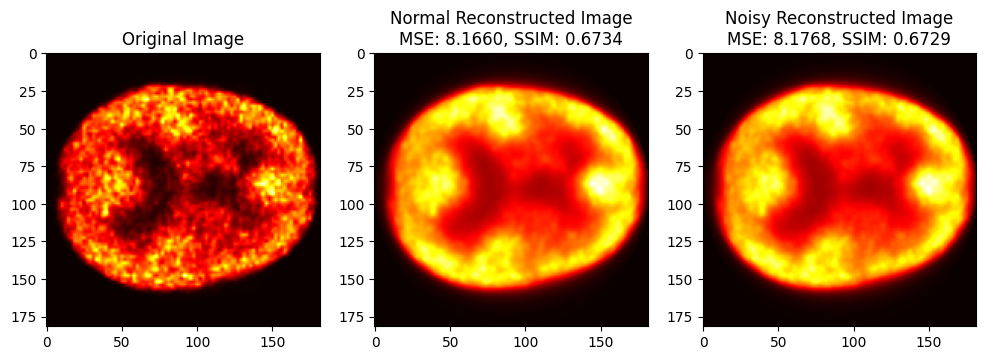

In [16]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

mlem_rec_norm = mlem_reco(sinogram, azi_angles)
mlem_rec_noisy = mlem_reco(noisy_sino, azi_angles)

# Compute metrics
mse_val_norm = mean_squared_error(true_object_cropped, mlem_rec_norm)
ssim_val_norm = ssim(true_object_cropped, mlem_rec_norm, data_range=true_object_cropped.max() - true_object_cropped.min())

mse_val_noisy = mean_squared_error(true_object_cropped, mlem_rec_noisy)
ssim_val_noisy = ssim(true_object_cropped, mlem_rec_noisy, data_range=true_object_cropped.max() - true_object_cropped.min())

fig, axs = plt.subplots(1, 3, figsize=(12,5))
axs[0].imshow(true_object_cropped, cmap ='hot')
axs[0].set_title("Original Image")

axs[1].imshow(mlem_rec_norm, cmap = 'hot')
axs[1].set_title(f"Normal Reconstructed Image\nMSE: {mse_val_norm:.4f}, SSIM: {ssim_val_norm:.4f}")

axs[2].imshow(mlem_rec_noisy, cmap = 'hot')
axs[2].set_title(f"Noisy Reconstructed Image\nMSE: {mse_val_noisy:.4f}, SSIM: {ssim_val_noisy:.4f}")

In [ ]:
#Comparing for different noise levels

#Noise Counts
max_counts = [1e4, 3e4, 5e4, 1e5, 5e5, 1e6]

mse_scores = []
ssim_scores = []

for counts in max_counts:

    noisy_sino = add_poisson(sinogram, max_counts=counts)

    recon_image = mlem_reco(noisy_sino, azi_angles)

    mse = mean_squared_error(true_object_cropped, recon_image)
    ssim_val = ssim(true_object_cropped, recon_image, data_range=true_object_cropped.max() - true_object_cropped.min())

    mse_scores.append(mse)
    ssim_scores.append(ssim_val)




[5.039501759024834, 5.037005877312527, 5.029093538854317, 5.024804106834313, 5.025683544181783, 5.025467638654604]
[0.7880225183658269, 0.7876615327684011, 0.7879055473767628, 0.7881991357708998, 0.7881180028505081, 0.7881056982845104]


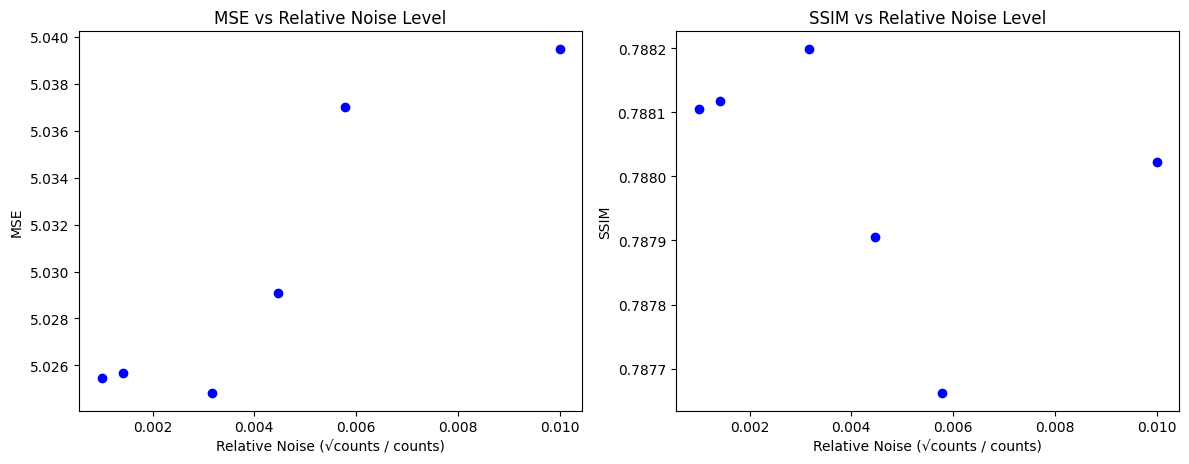

In [26]:
relative_noise = [np.sqrt(c) / c for c in max_counts]

print(mse_scores)
print(ssim_scores)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot MSE
axes[0].plot(relative_noise, mse_scores, 'bo')
axes[0].set_title('MSE vs Relative Noise Level')
axes[0].set_xlabel('Relative Noise (√counts / counts)')
axes[0].set_ylabel('MSE')

# Plot SSIM
axes[1].plot(relative_noise, ssim_scores, 'bo')
axes[1].set_title('SSIM vs Relative Noise Level')
axes[1].set_xlabel('Relative Noise (√counts / counts)')
axes[1].set_ylabel('SSIM')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
